# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

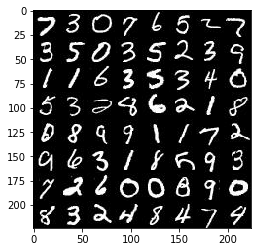

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

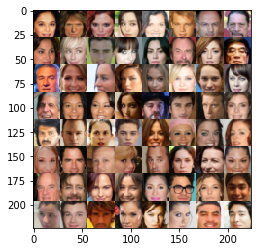

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: The leakage amount from the relus.
    :param dropout: How much dropout we want for trainning the discriminator
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: The leakage amount from the relus.
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param alpha: The leakage amount from the relus.
    :param dropout: How much dropout we want for trainning the discriminator
    :param smooth: How much do we want to smooth the discriminator so it is not that strong.
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=leaky_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting trainning")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    print("Finished with trainning")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting trainning
Step: 10: Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.2165
Step: 20: Epoch 1/2... Discriminator Loss: 1.8754... Generator Loss: 2.3064
Step: 30: Epoch 1/2... Discriminator Loss: 2.0891... Generator Loss: 2.7366
Step: 40: Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.9505
Step: 50: Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.5274
Step: 60: Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.2615
Step: 70: Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 1.4023
Step: 80: Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 3.8684
Step: 90: Epoch 1/2... Discriminator Loss: 1.6858... Generator Loss: 0.3990
Step: 100: Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 1.6524


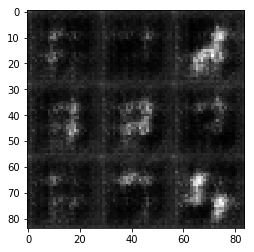

Step: 110: Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.9809
Step: 120: Epoch 1/2... Discriminator Loss: 1.5351... Generator Loss: 2.3921
Step: 130: Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 0.9651
Step: 140: Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.6045
Step: 150: Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 2.5431
Step: 160: Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 0.6515
Step: 170: Epoch 1/2... Discriminator Loss: 1.8774... Generator Loss: 3.7983
Step: 180: Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.4728
Step: 190: Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.6133
Step: 200: Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.6129


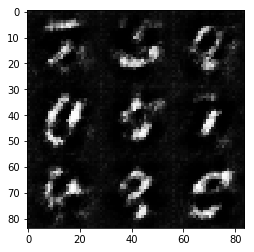

Step: 210: Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.7879
Step: 220: Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.4831
Step: 230: Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.9297
Step: 240: Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.5524
Step: 250: Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.6060
Step: 260: Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.4342
Step: 270: Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 2.0051
Step: 280: Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.0599
Step: 290: Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 1.4659
Step: 300: Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 0.7662


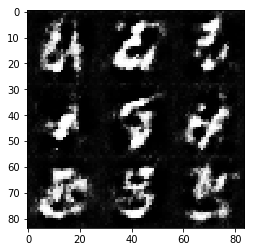

Step: 310: Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 1.3691
Step: 320: Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 2.8361
Step: 330: Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.7203
Step: 340: Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.0969
Step: 350: Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.0021
Step: 360: Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.6929
Step: 370: Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.9350
Step: 380: Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 2.3780
Step: 390: Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.6793
Step: 400: Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.6382


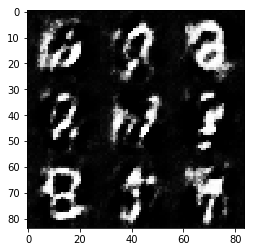

Step: 410: Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.8821
Step: 420: Epoch 1/2... Discriminator Loss: 1.8979... Generator Loss: 0.3003
Step: 430: Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.2508
Step: 440: Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 1.5900
Step: 450: Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.6052
Step: 460: Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.9500
Step: 470: Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5352
Step: 480: Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 1.5384
Step: 490: Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.0927
Step: 500: Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.2913


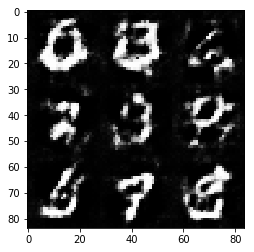

Step: 510: Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 1.4411
Step: 520: Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.8243
Step: 530: Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.5703
Step: 540: Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.2022
Step: 550: Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.7865
Step: 560: Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 2.2810
Step: 570: Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.8374
Step: 580: Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 0.9325
Step: 590: Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 1.3262
Step: 600: Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 2.0605


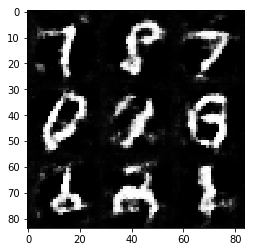

Step: 610: Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.6998
Step: 620: Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.9173
Step: 630: Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.5169
Step: 640: Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.2008
Step: 650: Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6099
Step: 660: Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.4955
Step: 670: Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.8168
Step: 680: Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.6287
Step: 690: Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 2.4998
Step: 700: Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.5177


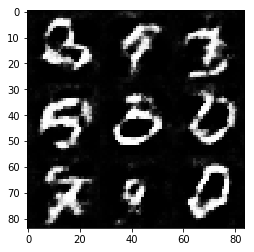

Step: 710: Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.6168
Step: 720: Epoch 1/2... Discriminator Loss: 1.7208... Generator Loss: 0.3478
Step: 730: Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 2.4489
Step: 740: Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.4879
Step: 750: Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.6150
Step: 760: Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.8772
Step: 770: Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.7367
Step: 780: Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 1.1479
Step: 790: Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.6036
Step: 800: Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 0.9096


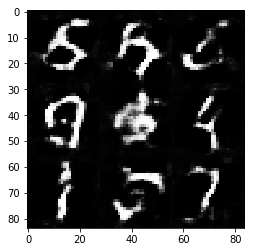

Step: 810: Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.6779
Step: 820: Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 0.9311
Step: 830: Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 0.3609
Step: 840: Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 0.3899
Step: 850: Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.1518
Step: 860: Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 0.9152
Step: 870: Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 1.6684
Step: 880: Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 1.7889
Step: 890: Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 1.3281
Step: 900: Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.6969


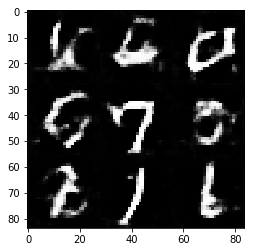

Step: 910: Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.7681
Step: 920: Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.7909
Step: 930: Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.4187
Step: 940: Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.0340
Step: 950: Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.8270
Step: 960: Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.5139
Step: 970: Epoch 1/2... Discriminator Loss: 1.7749... Generator Loss: 0.3098
Step: 980: Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.9780
Step: 990: Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.5174
Step: 1000: Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 0.7127


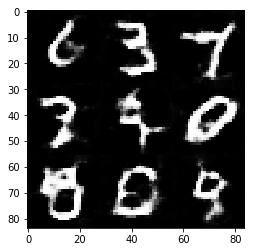

Step: 1010: Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 0.9598
Step: 1020: Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6404
Step: 1030: Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.6084
Step: 1040: Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.7011
Step: 1050: Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.6742
Step: 1060: Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 0.9109
Step: 1070: Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.3018
Step: 1080: Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.9946
Step: 1090: Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 0.3863
Step: 1100: Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.6610


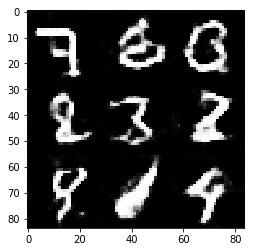

Step: 1110: Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4374
Step: 1120: Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.9794
Step: 1130: Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.4511
Step: 1140: Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 1.7782
Step: 1150: Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.7036
Step: 1160: Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.8793
Step: 1170: Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 0.9360
Step: 1180: Epoch 1/2... Discriminator Loss: 2.9289... Generator Loss: 4.1706
Step: 1190: Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5000
Step: 1200: Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 0.9852


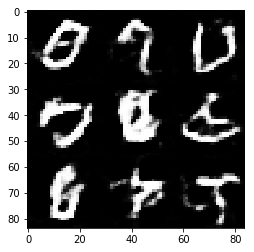

Step: 1210: Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.2957
Step: 1220: Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.5710
Step: 1230: Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.7299
Step: 1240: Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.5189
Step: 1250: Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 0.9254
Step: 1260: Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.7993
Step: 1270: Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.2790
Step: 1280: Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 1.1317
Step: 1290: Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 0.9687
Step: 1300: Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.2345


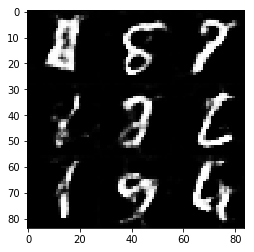

Step: 1310: Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.7588
Step: 1320: Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.2294
Step: 1330: Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8203
Step: 1340: Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 0.9269
Step: 1350: Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 1.7057
Step: 1360: Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 0.7683
Step: 1370: Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.6165
Step: 1380: Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 1.5345
Step: 1390: Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.6504
Step: 1400: Epoch 1/2... Discriminator Loss: 3.3714... Generator Loss: 5.8312


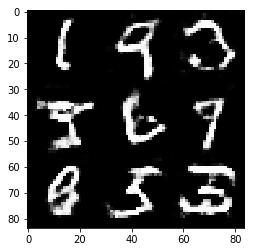

Step: 1410: Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.5884
Step: 1420: Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.9027
Step: 1430: Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.3972
Step: 1440: Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.5419
Step: 1450: Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.8085
Step: 1460: Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 2.1382
Step: 1470: Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.9214
Step: 1480: Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.7277
Step: 1490: Epoch 1/2... Discriminator Loss: 1.9214... Generator Loss: 0.4361
Step: 1500: Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.2296


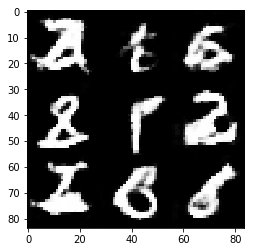

Step: 1510: Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.3124
Step: 1520: Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 0.9555
Step: 1530: Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 0.9707
Step: 1540: Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 2.2528
Step: 1550: Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.9656
Step: 1560: Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.4509
Step: 1570: Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.6458
Step: 1580: Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.5622
Step: 1590: Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.1007
Step: 1600: Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.1091


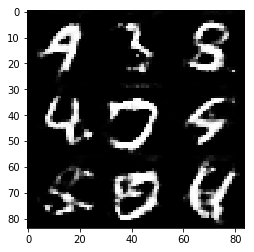

Step: 1610: Epoch 1/2... Discriminator Loss: 2.3867... Generator Loss: 0.2566
Step: 1620: Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.8404
Step: 1630: Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 1.5167
Step: 1640: Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.2557
Step: 1650: Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 1.2577
Step: 1660: Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.0429
Step: 1670: Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.4543
Step: 1680: Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.6262
Step: 1690: Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 3.2744
Step: 1700: Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.7755


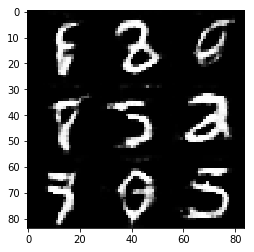

Step: 1710: Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.7093
Step: 1720: Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 0.9455
Step: 1730: Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.2785
Step: 1740: Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.8390
Step: 1750: Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 0.9426
Step: 1760: Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.7344
Step: 1770: Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.4244
Step: 1780: Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 0.9913
Step: 1790: Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 1.8244
Step: 1800: Epoch 1/2... Discriminator Loss: 1.8244... Generator Loss: 0.3035


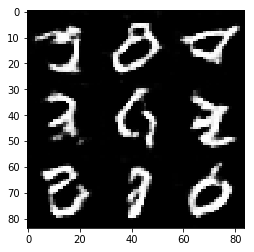

Step: 1810: Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 0.8379
Step: 1820: Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.6087
Step: 1830: Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.6843
Step: 1840: Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.7569
Step: 1850: Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.2848
Step: 1860: Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.8315
Step: 1870: Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.9361
Step: 1880: Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.0932
Step: 1890: Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 2.4084
Step: 1900: Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.2101


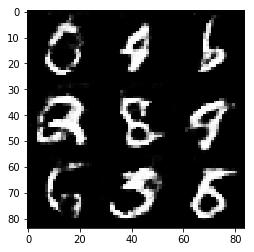

Step: 1910: Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.7064
Step: 1920: Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.7642
Step: 1930: Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.8143
Step: 1940: Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.2532
Step: 1950: Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.1590
Step: 1960: Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.5042
Step: 1970: Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.6108
Step: 1980: Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.0213
Step: 1990: Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.6476
Step: 2000: Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8864


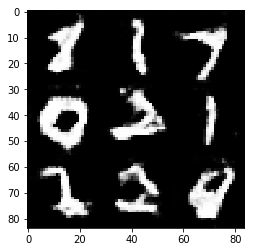

Step: 2010: Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.8641
Step: 2020: Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.4446
Step: 2030: Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.8739
Step: 2040: Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.2591
Step: 2050: Epoch 2/2... Discriminator Loss: 2.1448... Generator Loss: 0.2488
Step: 2060: Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.6171
Step: 2070: Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 1.3161
Step: 2080: Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.3147
Step: 2090: Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.9231
Step: 2100: Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.6300


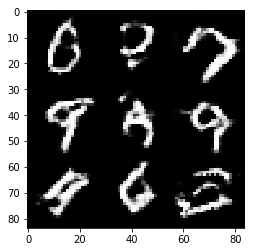

Step: 2110: Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.4960
Step: 2120: Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.8179
Step: 2130: Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.3512
Step: 2140: Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 0.9343
Step: 2150: Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.5419
Step: 2160: Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 0.8286
Step: 2170: Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.6233
Step: 2180: Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.2183
Step: 2190: Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 1.5971
Step: 2200: Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 1.7219


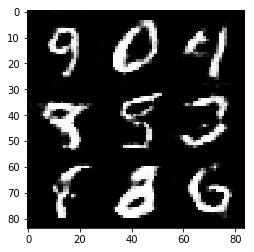

Step: 2210: Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.5227
Step: 2220: Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.7754
Step: 2230: Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 2.1096
Step: 2240: Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.0885
Step: 2250: Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.0591
Step: 2260: Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.1658
Step: 2270: Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.1590
Step: 2280: Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 0.9312
Step: 2290: Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.2209
Step: 2300: Epoch 2/2... Discriminator Loss: 1.9453... Generator Loss: 4.1524


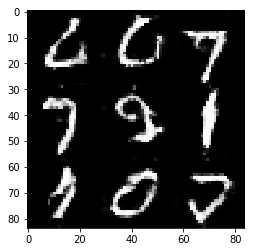

Step: 2310: Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.9942
Step: 2320: Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 0.9136
Step: 2330: Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.1801
Step: 2340: Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.1511
Step: 2350: Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 0.9833
Step: 2360: Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.3454
Step: 2370: Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.4104
Step: 2380: Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.8183
Step: 2390: Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.5641
Step: 2400: Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.7979


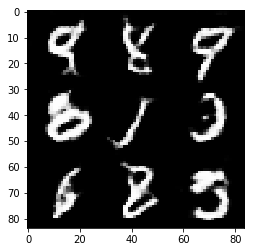

Step: 2410: Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 0.9192
Step: 2420: Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 2.6482
Step: 2430: Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.7814
Step: 2440: Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 1.1710
Step: 2450: Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.3875
Step: 2460: Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 1.0349
Step: 2470: Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.5534
Step: 2480: Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 0.9702
Step: 2490: Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.8749
Step: 2500: Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 2.5352


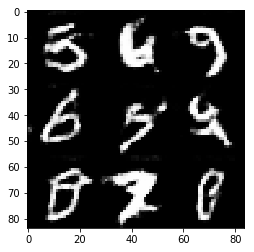

Step: 2510: Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.5676
Step: 2520: Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.3016
Step: 2530: Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.8702
Step: 2540: Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.6177
Step: 2550: Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.7180
Step: 2560: Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.3330
Step: 2570: Epoch 2/2... Discriminator Loss: 0.6384... Generator Loss: 1.5716
Step: 2580: Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.4774
Step: 2590: Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 2.3358
Step: 2600: Epoch 2/2... Discriminator Loss: 1.7939... Generator Loss: 0.3792


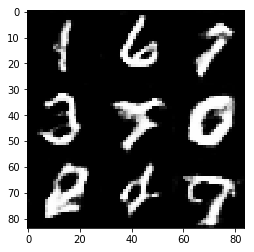

Step: 2610: Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.0248
Step: 2620: Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.2472
Step: 2630: Epoch 2/2... Discriminator Loss: 1.9857... Generator Loss: 0.3214
Step: 2640: Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 1.8592
Step: 2650: Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.3914
Step: 2660: Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 0.9159
Step: 2670: Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9076
Step: 2680: Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 1.0112
Step: 2690: Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 2.4149
Step: 2700: Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 3.5199


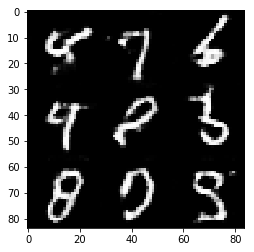

Step: 2710: Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.0047
Step: 2720: Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.0779
Step: 2730: Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 1.1753
Step: 2740: Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.4098
Step: 2750: Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.3467
Step: 2760: Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.8051
Step: 2770: Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.1811
Step: 2780: Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.7328
Step: 2790: Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.0016
Step: 2800: Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0455


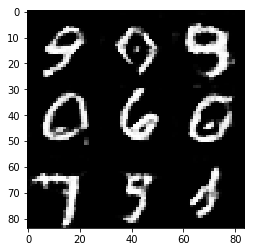

Step: 2810: Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.3244
Step: 2820: Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 2.6813
Step: 2830: Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 2.3773
Step: 2840: Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.9446
Step: 2850: Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.2325
Step: 2860: Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.9547
Step: 2870: Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.5794
Step: 2880: Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.2185
Step: 2890: Epoch 2/2... Discriminator Loss: 0.6273... Generator Loss: 1.7760
Step: 2900: Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 0.7119


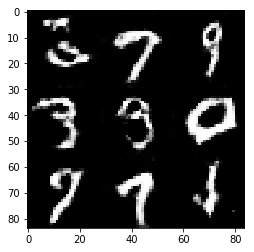

Step: 2910: Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 0.9530
Step: 2920: Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.7268
Step: 2930: Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 2.9013
Step: 2940: Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.7796
Step: 2950: Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.2483
Step: 2960: Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.3676
Step: 2970: Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.3240
Step: 2980: Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.7110
Step: 2990: Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.7935
Step: 3000: Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.9900


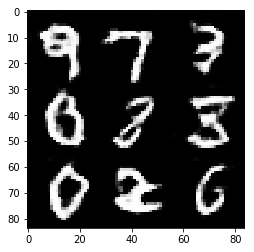

Step: 3010: Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.6050
Step: 3020: Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.7393
Step: 3030: Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 0.9602
Step: 3040: Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 0.6924
Step: 3050: Epoch 2/2... Discriminator Loss: 1.9443... Generator Loss: 0.3505
Step: 3060: Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.4908
Step: 3070: Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.7658
Step: 3080: Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.2564
Step: 3090: Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 1.7575
Step: 3100: Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.4564


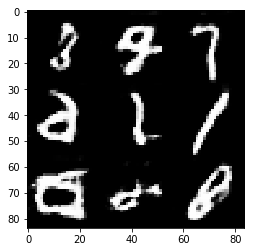

Step: 3110: Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.6614
Step: 3120: Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.8849
Step: 3130: Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 0.9433
Step: 3140: Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 2.2611
Step: 3150: Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.9821
Step: 3160: Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.9698
Step: 3170: Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.3125
Step: 3180: Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.0688
Step: 3190: Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 0.5948
Step: 3200: Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.2372


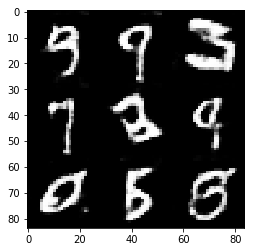

Step: 3210: Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.8901
Step: 3220: Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.5453
Step: 3230: Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.6000
Step: 3240: Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.8913
Step: 3250: Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.7759
Step: 3260: Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.0805
Step: 3270: Epoch 2/2... Discriminator Loss: 1.6042... Generator Loss: 0.4764
Step: 3280: Epoch 2/2... Discriminator Loss: 3.3844... Generator Loss: 0.1294
Step: 3290: Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.3710
Step: 3300: Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.7585


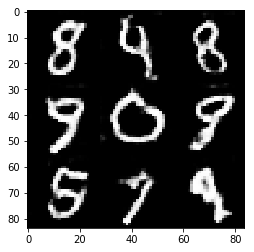

Step: 3310: Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.8359
Step: 3320: Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.8354
Step: 3330: Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.0039
Step: 3340: Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 3.4724
Step: 3350: Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.5814
Step: 3360: Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 0.5602
Step: 3370: Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.4082
Step: 3380: Epoch 2/2... Discriminator Loss: 0.6828... Generator Loss: 1.4366
Step: 3390: Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 0.9506
Step: 3400: Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 1.3207


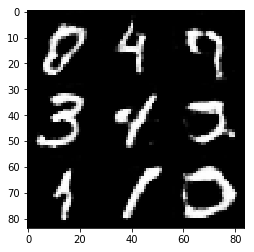

Step: 3410: Epoch 2/2... Discriminator Loss: 3.3107... Generator Loss: 0.1209
Step: 3420: Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.5945
Step: 3430: Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 1.7706
Step: 3440: Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.4307
Step: 3450: Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 0.7514
Step: 3460: Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 1.9458
Step: 3470: Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.3173
Step: 3480: Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 2.6144
Step: 3490: Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.2158
Step: 3500: Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.2473


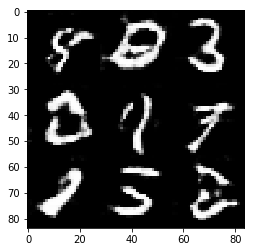

Step: 3510: Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.0026
Step: 3520: Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.6697
Step: 3530: Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.1361
Step: 3540: Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.2882
Step: 3550: Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.7271
Step: 3560: Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 1.6961
Step: 3570: Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.0227
Step: 3580: Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 1.5210
Step: 3590: Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.4787
Step: 3600: Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 1.5026


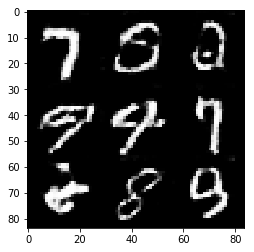

Step: 3610: Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.7932
Step: 3620: Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.3473
Step: 3630: Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 2.4645
Step: 3640: Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.5807
Step: 3650: Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.1859
Step: 3660: Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 1.4938
Step: 3670: Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0739
Step: 3680: Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.0280
Step: 3690: Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.9680
Step: 3700: Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.2938


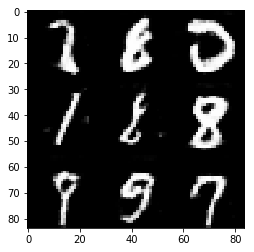

Step: 3710: Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 1.5380
Step: 3720: Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 0.9631
Step: 3730: Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.0914
Step: 3740: Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.0828
Step: 3750: Epoch 2/2... Discriminator Loss: 2.6990... Generator Loss: 5.0359
Finished with trainning


In [30]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting trainning
Step: 10: Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.9831
Step: 20: Epoch 1/2... Discriminator Loss: 0.5422... Generator Loss: 2.2551
Step: 30: Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 1.5336
Step: 40: Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.7220
Step: 50: Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 3.3246
Step: 60: Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 2.2061
Step: 70: Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.9692
Step: 80: Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.6563
Step: 90: Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 0.4266
Step: 100: Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.8043


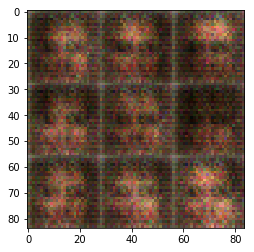

Step: 110: Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 2.1195
Step: 120: Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.5081
Step: 130: Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 1.2365
Step: 140: Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.5604
Step: 150: Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.2045
Step: 160: Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.5433
Step: 170: Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 1.0552
Step: 180: Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.0139
Step: 190: Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.5841
Step: 200: Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.1696


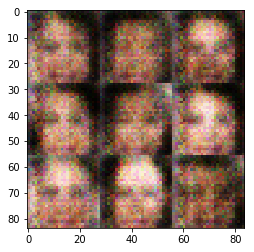

Step: 210: Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 1.1808
Step: 220: Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.0290
Step: 230: Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.7268
Step: 240: Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 1.6078
Step: 250: Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 0.9921
Step: 260: Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.6138
Step: 270: Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 1.1839
Step: 280: Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.0857
Step: 290: Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 0.8110
Step: 300: Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.4874


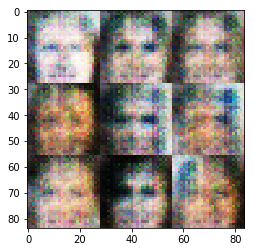

Step: 310: Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.6653
Step: 320: Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 0.6887
Step: 330: Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.4896
Step: 340: Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 2.4817
Step: 350: Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.3861
Step: 360: Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.1268
Step: 370: Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.1290
Step: 380: Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.2510
Step: 390: Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.6097
Step: 400: Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 2.7442


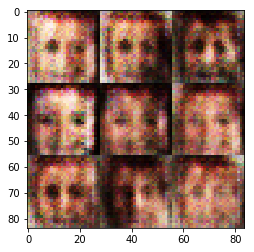

Step: 410: Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.6897
Step: 420: Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.5944
Step: 430: Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.7551
Step: 440: Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.4260
Step: 450: Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.6079
Step: 460: Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 3.3256
Step: 470: Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 1.6427
Step: 480: Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 2.2115
Step: 490: Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 1.3156
Step: 500: Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.3153


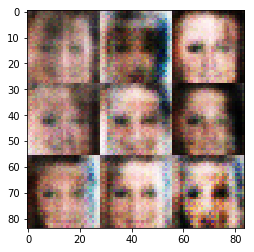

Step: 510: Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.6090
Step: 520: Epoch 1/2... Discriminator Loss: 0.8498... Generator Loss: 1.3097
Step: 530: Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.6163
Step: 540: Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 2.7159
Step: 550: Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.3206
Step: 560: Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 2.4503
Step: 570: Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.5551
Step: 580: Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.9893
Step: 590: Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.4921
Step: 600: Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.6363


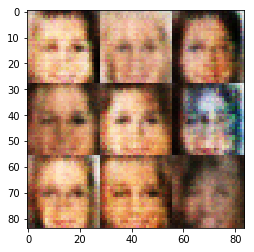

Step: 610: Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.1383
Step: 620: Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.5394
Step: 630: Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.6517
Step: 640: Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.7584
Step: 650: Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.4369
Step: 660: Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 1.8815
Step: 670: Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 2.3211
Step: 680: Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 2.2260
Step: 690: Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.7932
Step: 700: Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.6798


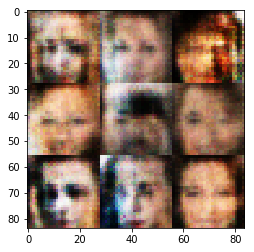

Step: 710: Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 0.9566
Step: 720: Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 1.0618
Step: 730: Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.9710
Step: 740: Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.7604
Step: 750: Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8399
Step: 760: Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 2.0434
Step: 770: Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 1.1897
Step: 780: Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.4749
Step: 790: Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 2.2427
Step: 800: Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.6615


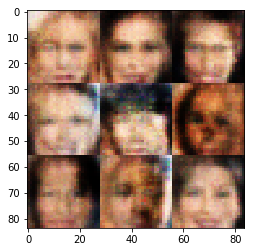

Step: 810: Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.5842
Step: 820: Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.5165
Step: 830: Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.7287
Step: 840: Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.6245
Step: 850: Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 2.2617
Step: 860: Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 2.6276
Step: 870: Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.7991
Step: 880: Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.7888
Step: 890: Epoch 1/2... Discriminator Loss: 1.4679... Generator Loss: 3.4248
Step: 900: Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.6799


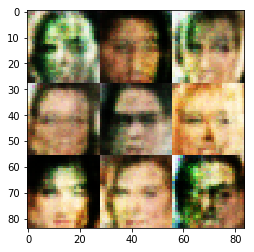

Step: 910: Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.1221
Step: 920: Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.5793
Step: 930: Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.1232
Step: 940: Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.5527
Step: 950: Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.5949
Step: 960: Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 0.6934
Step: 970: Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.6932
Step: 980: Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 2.0418
Step: 990: Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.8616
Step: 1000: Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.6787


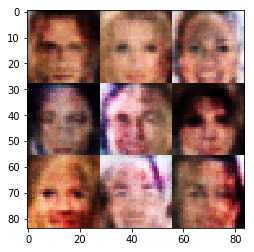

Step: 1010: Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.2072
Step: 1020: Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 2.8102
Step: 1030: Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 2.7456
Step: 1040: Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 2.6625
Step: 1050: Epoch 1/2... Discriminator Loss: 1.6681... Generator Loss: 0.3532
Step: 1060: Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.1661
Step: 1070: Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 2.4269
Step: 1080: Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.7129
Step: 1090: Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.9294
Step: 1100: Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 1.4170


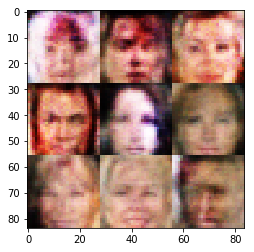

Step: 1110: Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 0.9139
Step: 1120: Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.4517
Step: 1130: Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.3767
Step: 1140: Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.5773
Step: 1150: Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.4511
Step: 1160: Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 0.8645
Step: 1170: Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 2.3209
Step: 1180: Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 2.3317
Step: 1190: Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.7700
Step: 1200: Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.2077


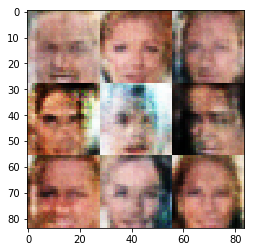

Step: 1210: Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.5242
Step: 1220: Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.9082
Step: 1230: Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.6916
Step: 1240: Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 0.8828
Step: 1250: Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 1.3939
Step: 1260: Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6013
Step: 1270: Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0039
Step: 1280: Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 1.6582
Step: 1290: Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 2.0558
Step: 1300: Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.7735


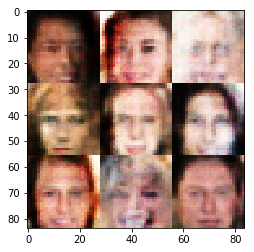

Step: 1310: Epoch 1/2... Discriminator Loss: 1.8193... Generator Loss: 0.2954
Step: 1320: Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.5486
Step: 1330: Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 0.9402
Step: 1340: Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.5817
Step: 1350: Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.8769
Step: 1360: Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 2.8232
Step: 1370: Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 1.2031
Step: 1380: Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.1549
Step: 1390: Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.8571
Step: 1400: Epoch 1/2... Discriminator Loss: 2.0879... Generator Loss: 0.2484


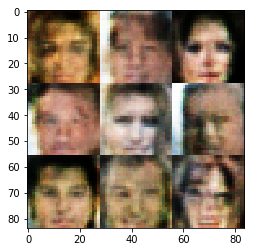

Step: 1410: Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.4634
Step: 1420: Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.1064
Step: 1430: Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 2.3388
Step: 1440: Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.6047
Step: 1450: Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.7474
Step: 1460: Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 2.0147
Step: 1470: Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 3.8346
Step: 1480: Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 1.3475
Step: 1490: Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 1.4127
Step: 1500: Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.5650


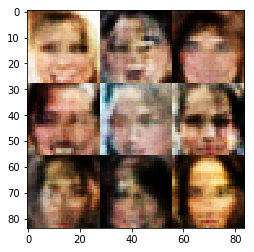

Step: 1510: Epoch 1/2... Discriminator Loss: 2.5682... Generator Loss: 0.1758
Step: 1520: Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.4680
Step: 1530: Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 1.8834
Step: 1540: Epoch 1/2... Discriminator Loss: 1.8066... Generator Loss: 0.3416
Step: 1550: Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 0.9891
Step: 1560: Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.7407
Step: 1570: Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.5997
Step: 1580: Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 0.3670
Step: 1590: Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.7401
Step: 1600: Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 0.3228


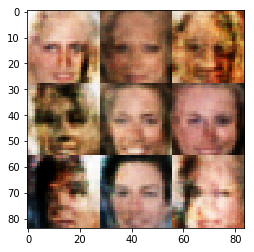

Step: 1610: Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 1.7544
Step: 1620: Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.2731
Step: 1630: Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 3.4669
Step: 1640: Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 4.4238
Step: 1650: Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 2.0932
Step: 1660: Epoch 1/2... Discriminator Loss: 0.6218... Generator Loss: 2.8912
Step: 1670: Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 3.8159
Step: 1680: Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 3.1196
Step: 1690: Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 2.5243
Step: 1700: Epoch 1/2... Discriminator Loss: 0.6027... Generator Loss: 2.1368


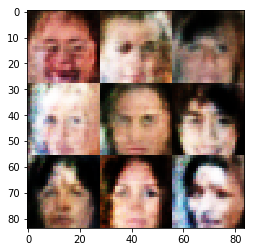

Step: 1710: Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 3.2533
Step: 1720: Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 1.9574
Step: 1730: Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 5.1747
Step: 1740: Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.7430
Step: 1750: Epoch 1/2... Discriminator Loss: 0.8909... Generator Loss: 0.9233
Step: 1760: Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.6878
Step: 1770: Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 0.8848
Step: 1780: Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.6696
Step: 1790: Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 2.5397
Step: 1800: Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.5096


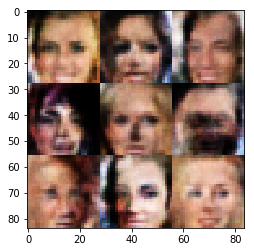

Step: 1810: Epoch 1/2... Discriminator Loss: 0.4932... Generator Loss: 2.1456
Step: 1820: Epoch 1/2... Discriminator Loss: 0.5124... Generator Loss: 2.3297
Step: 1830: Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 0.8899
Step: 1840: Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.6045
Step: 1850: Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.0287
Step: 1860: Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.7080
Step: 1870: Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 3.4593
Step: 1880: Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.4247
Step: 1890: Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 4.0836
Step: 1900: Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 2.7608


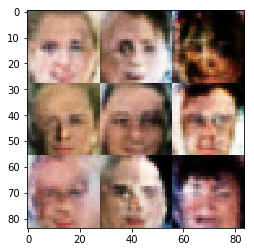

Step: 1910: Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 5.2942
Step: 1920: Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 2.6358
Step: 1930: Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.0088
Step: 1940: Epoch 1/2... Discriminator Loss: 1.7801... Generator Loss: 0.3368
Step: 1950: Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 3.7542
Step: 1960: Epoch 1/2... Discriminator Loss: 0.4142... Generator Loss: 2.8888
Step: 1970: Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 2.5565
Step: 1980: Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 3.0414
Step: 1990: Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 2.5915
Step: 2000: Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 3.1971


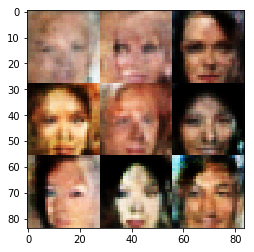

Step: 2010: Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 3.2720
Step: 2020: Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.0972
Step: 2030: Epoch 1/2... Discriminator Loss: 2.6040... Generator Loss: 0.1625
Step: 2040: Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 1.6797
Step: 2050: Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 3.6342
Step: 2060: Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.5592
Step: 2070: Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 2.5322
Step: 2080: Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 3.8569
Step: 2090: Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 3.9979
Step: 2100: Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 4.1600


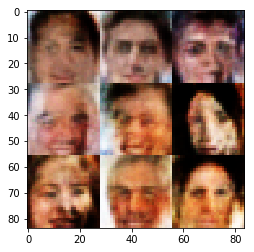

Step: 2110: Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 2.1011
Step: 2120: Epoch 1/2... Discriminator Loss: 0.6182... Generator Loss: 2.9574
Step: 2130: Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 4.2015
Step: 2140: Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 4.4914
Step: 2150: Epoch 1/2... Discriminator Loss: 0.4620... Generator Loss: 3.0848
Step: 2160: Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.4489
Step: 2170: Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 1.8660
Step: 2180: Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.5336
Step: 2190: Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 3.4725
Step: 2200: Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 4.1880


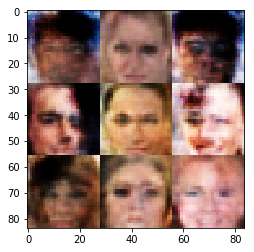

Step: 2210: Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 3.4260
Step: 2220: Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 2.5843
Step: 2230: Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.2389
Step: 2240: Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 2.3053
Step: 2250: Epoch 1/2... Discriminator Loss: 0.5305... Generator Loss: 4.2232
Step: 2260: Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.3673
Step: 2270: Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 2.5087
Step: 2280: Epoch 1/2... Discriminator Loss: 0.5234... Generator Loss: 1.9461
Step: 2290: Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 3.1774
Step: 2300: Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 4.5877


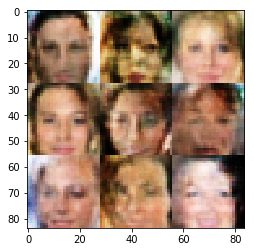

Step: 2310: Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.1644
Step: 2320: Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 2.2682
Step: 2330: Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 2.8038
Step: 2340: Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 2.5878
Step: 2350: Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 4.9038
Step: 2360: Epoch 1/2... Discriminator Loss: 4.3109... Generator Loss: 3.9909
Step: 2370: Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.8562
Step: 2380: Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 3.0867
Step: 2390: Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.3713
Step: 2400: Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.8616


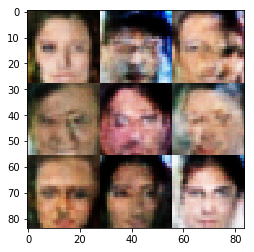

Step: 2410: Epoch 1/2... Discriminator Loss: 0.4594... Generator Loss: 2.5776
Step: 2420: Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 2.8984
Step: 2430: Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.7775
Step: 2440: Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 2.4038
Step: 2450: Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 3.7633
Step: 2460: Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 1.6483
Step: 2470: Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.8426
Step: 2480: Epoch 1/2... Discriminator Loss: 1.6352... Generator Loss: 2.1579
Step: 2490: Epoch 1/2... Discriminator Loss: 0.4327... Generator Loss: 2.7632
Step: 2500: Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 2.0213


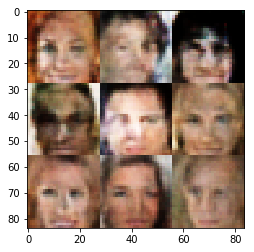

Step: 2510: Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 2.9882
Step: 2520: Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 0.7009
Step: 2530: Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 1.6710
Step: 2540: Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 1.0243
Step: 2550: Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.7873
Step: 2560: Epoch 1/2... Discriminator Loss: 0.4009... Generator Loss: 3.1018
Step: 2570: Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 4.2215
Step: 2580: Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 2.4983
Step: 2590: Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 1.7860
Step: 2600: Epoch 1/2... Discriminator Loss: 1.7804... Generator Loss: 2.9805


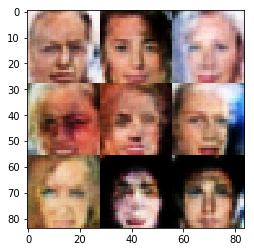

Step: 2610: Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 2.6840
Step: 2620: Epoch 1/2... Discriminator Loss: 0.8500... Generator Loss: 1.8188
Step: 2630: Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 2.2823
Step: 2640: Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.2741
Step: 2650: Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 1.6082
Step: 2660: Epoch 1/2... Discriminator Loss: 0.4410... Generator Loss: 2.5846
Step: 2670: Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 2.5141
Step: 2680: Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 3.2117
Step: 2690: Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 3.7503
Step: 2700: Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 2.3976


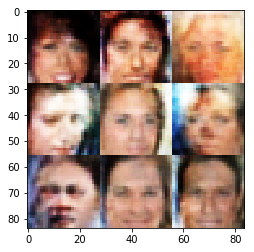

Step: 2710: Epoch 1/2... Discriminator Loss: 0.4799... Generator Loss: 2.8888
Step: 2720: Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 2.4938
Step: 2730: Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 4.7279
Step: 2740: Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.5726
Step: 2750: Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 1.5085
Step: 2760: Epoch 1/2... Discriminator Loss: 0.3757... Generator Loss: 4.0172
Step: 2770: Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 2.8460
Step: 2780: Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 4.0006
Step: 2790: Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 2.8443
Step: 2800: Epoch 1/2... Discriminator Loss: 0.4436... Generator Loss: 3.5931


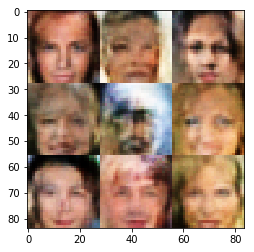

Step: 2810: Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 3.0258
Step: 2820: Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 2.6098
Step: 2830: Epoch 1/2... Discriminator Loss: 3.7706... Generator Loss: 5.5813
Step: 2840: Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.2415
Step: 2850: Epoch 1/2... Discriminator Loss: 0.5401... Generator Loss: 1.8542
Step: 2860: Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 2.7672
Step: 2870: Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 2.6711
Step: 2880: Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.6757
Step: 2890: Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 3.7482
Step: 2900: Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.7834


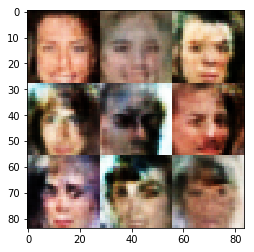

Step: 2910: Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 3.1808
Step: 2920: Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.9074
Step: 2930: Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 2.7190
Step: 2940: Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 2.1223
Step: 2950: Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 3.7500
Step: 2960: Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 2.1821
Step: 2970: Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 2.2526
Step: 2980: Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 3.4811
Step: 2990: Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 2.7790
Step: 3000: Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.5869


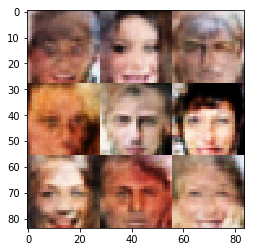

Step: 3010: Epoch 1/2... Discriminator Loss: 2.7351... Generator Loss: 4.5800
Step: 3020: Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 2.1954
Step: 3030: Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 2.7371
Step: 3040: Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 2.6258
Step: 3050: Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 2.1078
Step: 3060: Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 2.2582
Step: 3070: Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 1.6008
Step: 3080: Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 2.2167
Step: 3090: Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 2.8642
Step: 3100: Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.7742


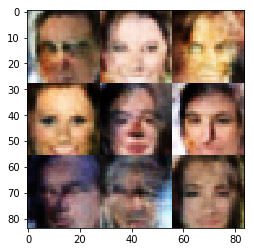

Step: 3110: Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.7488
Step: 3120: Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 3.7518
Step: 3130: Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 3.5076
Step: 3140: Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 1.7856
Step: 3150: Epoch 1/2... Discriminator Loss: 2.7686... Generator Loss: 0.1345
Step: 3160: Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 0.8589
Step: 3170: Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.6691
Step: 3180: Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.8059
Step: 3190: Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 2.1790
Step: 3200: Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.9599


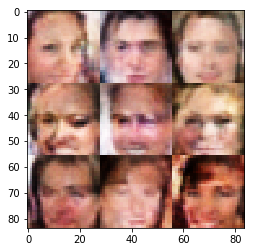

Step: 3210: Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 1.3959
Step: 3220: Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 3.1593
Step: 3230: Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 3.3511
Step: 3240: Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 3.0486
Step: 3250: Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.2344
Step: 3260: Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 2.1325
Step: 3270: Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 1.5902
Step: 3280: Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 4.3182
Step: 3290: Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 3.0660
Step: 3300: Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 1.7976


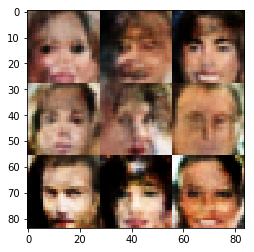

Step: 3310: Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.4826
Step: 3320: Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 2.9298
Step: 3330: Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 3.1152
Step: 3340: Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 2.0048
Step: 3350: Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.2670
Step: 3360: Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 3.5245
Step: 3370: Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 1.3081
Step: 3380: Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.4429
Step: 3390: Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 1.9775
Step: 3400: Epoch 1/2... Discriminator Loss: 0.8149... Generator Loss: 3.3554


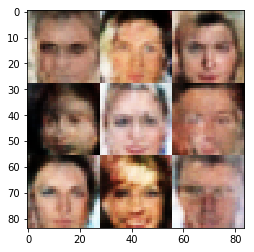

Step: 3410: Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 1.2180
Step: 3420: Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 1.0780
Step: 3430: Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 1.9412
Step: 3440: Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 2.1510
Step: 3450: Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 1.5884
Step: 3460: Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.6546
Step: 3470: Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.6907
Step: 3480: Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 3.9592
Step: 3490: Epoch 1/2... Discriminator Loss: 0.4178... Generator Loss: 3.2140
Step: 3500: Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 2.5393


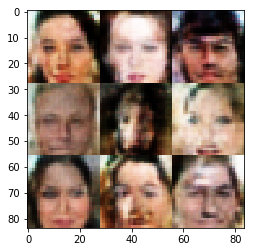

Step: 3510: Epoch 1/2... Discriminator Loss: 0.5457... Generator Loss: 1.8814
Step: 3520: Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 1.9956
Step: 3530: Epoch 1/2... Discriminator Loss: 2.8179... Generator Loss: 0.1501
Step: 3540: Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 2.0645
Step: 3550: Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.7733
Step: 3560: Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 4.3719
Step: 3570: Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 2.0488
Step: 3580: Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 2.8091
Step: 3590: Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.3011
Step: 3600: Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 1.8931


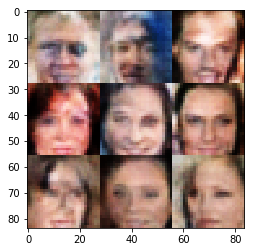

Step: 3610: Epoch 1/2... Discriminator Loss: 0.4420... Generator Loss: 2.4683
Step: 3620: Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.3726
Step: 3630: Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 0.9884
Step: 3640: Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.6994
Step: 3650: Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.4528
Step: 3660: Epoch 1/2... Discriminator Loss: 0.3807... Generator Loss: 4.1888
Step: 3670: Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 3.5944
Step: 3680: Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 3.8449
Step: 3690: Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 3.3408
Step: 3700: Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 3.2755


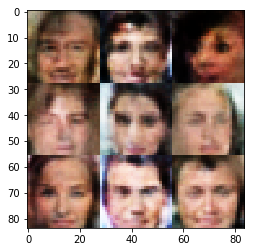

Step: 3710: Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.6566
Step: 3720: Epoch 1/2... Discriminator Loss: 0.4244... Generator Loss: 2.6895
Step: 3730: Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 2.0605
Step: 3740: Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 3.6382
Step: 3750: Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 3.1325
Step: 3760: Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 4.5422
Step: 3770: Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 1.8764
Step: 3780: Epoch 1/2... Discriminator Loss: 0.5647... Generator Loss: 2.1262
Step: 3790: Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 1.9108
Step: 3800: Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 0.9579


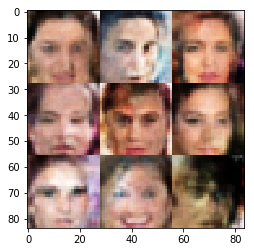

Step: 3810: Epoch 1/2... Discriminator Loss: 2.2420... Generator Loss: 3.5421
Step: 3820: Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.2491
Step: 3830: Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.7484
Step: 3840: Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 2.1849
Step: 3850: Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 3.2126
Step: 3860: Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 2.5610
Step: 3870: Epoch 1/2... Discriminator Loss: 0.4202... Generator Loss: 2.8975
Step: 3880: Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 0.9843
Step: 3890: Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.9592
Step: 3900: Epoch 1/2... Discriminator Loss: 0.4332... Generator Loss: 2.9221


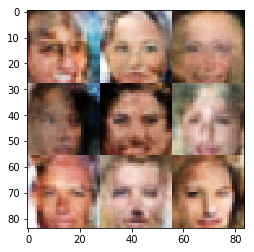

Step: 3910: Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 2.3052
Step: 3920: Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 2.0693
Step: 3930: Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 2.6941
Step: 3940: Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.2149
Step: 3950: Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.5381
Step: 3960: Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 3.9357
Step: 3970: Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 4.0048
Step: 3980: Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 1.3248
Step: 3990: Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 1.3504
Step: 4000: Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 3.2211


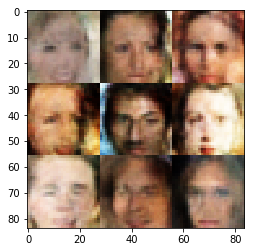

Step: 4010: Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 2.9435
Step: 4020: Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.6807
Step: 4030: Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.6436
Step: 4040: Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.1789
Step: 4050: Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.9933
Step: 4060: Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 2.1218
Step: 4070: Epoch 1/2... Discriminator Loss: 0.7053... Generator Loss: 1.3873
Step: 4080: Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 2.1258
Step: 4090: Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.3344
Step: 4100: Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.1492


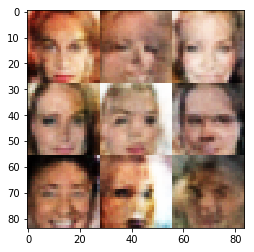

Step: 4110: Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.0147
Step: 4120: Epoch 1/2... Discriminator Loss: 0.4542... Generator Loss: 2.5618
Step: 4130: Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.4690
Step: 4140: Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 2.7091
Step: 4150: Epoch 1/2... Discriminator Loss: 0.4317... Generator Loss: 2.9119
Step: 4160: Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 2.2509
Step: 4170: Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 2.1404
Step: 4180: Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 2.7706
Step: 4190: Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.0374
Step: 4200: Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 2.0228


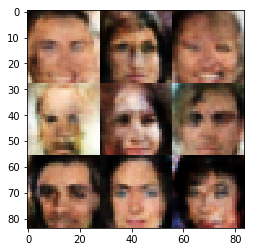

Step: 4210: Epoch 1/2... Discriminator Loss: 2.4147... Generator Loss: 0.1823
Step: 4220: Epoch 1/2... Discriminator Loss: 0.4107... Generator Loss: 3.6013
Step: 4230: Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.5025
Step: 4240: Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.3749
Step: 4250: Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.2765
Step: 4260: Epoch 1/2... Discriminator Loss: 0.5218... Generator Loss: 2.3430
Step: 4270: Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.5014
Step: 4280: Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 0.8584
Step: 4290: Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.4619
Step: 4300: Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 1.4106


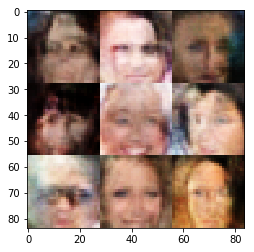

Step: 4310: Epoch 1/2... Discriminator Loss: 0.4536... Generator Loss: 2.6932
Step: 4320: Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 1.7574
Step: 4330: Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 1.9074
Step: 4340: Epoch 1/2... Discriminator Loss: 0.4729... Generator Loss: 2.4410
Step: 4350: Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.6844
Step: 4360: Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.4911
Step: 4370: Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 1.5615
Step: 4380: Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 3.1744
Step: 4390: Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.3754
Step: 4400: Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 1.0659


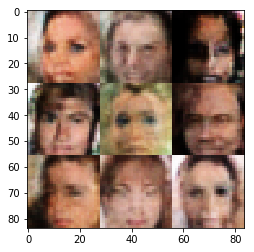

Step: 4410: Epoch 1/2... Discriminator Loss: 0.9842... Generator Loss: 0.9282
Step: 4420: Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 1.9257
Step: 4430: Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.4597
Step: 4440: Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 2.7081
Step: 4450: Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 1.8080
Step: 4460: Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.1505
Step: 4470: Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 4.1462
Step: 4480: Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 0.9953
Step: 4490: Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 1.3104
Step: 4500: Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 1.3316


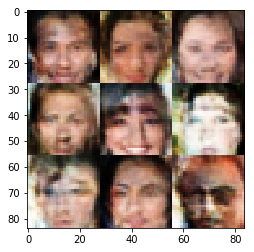

Step: 4510: Epoch 1/2... Discriminator Loss: 0.5218... Generator Loss: 2.6260
Step: 4520: Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 1.9711
Step: 4530: Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.5726
Step: 4540: Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 1.5707
Step: 4550: Epoch 1/2... Discriminator Loss: 1.9781... Generator Loss: 0.2911
Step: 4560: Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 2.9371
Step: 4570: Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.5876
Step: 4580: Epoch 1/2... Discriminator Loss: 1.7274... Generator Loss: 0.3592
Step: 4590: Epoch 1/2... Discriminator Loss: 0.7416... Generator Loss: 1.2782
Step: 4600: Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 1.8659


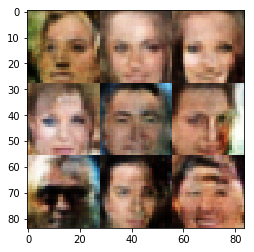

Step: 4610: Epoch 1/2... Discriminator Loss: 0.5841... Generator Loss: 2.4719
Step: 4620: Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 2.0715
Step: 4630: Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 0.8890
Step: 4640: Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 2.3338
Step: 4650: Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.6045
Step: 4660: Epoch 1/2... Discriminator Loss: 0.5325... Generator Loss: 1.9895
Step: 4670: Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 2.4914
Step: 4680: Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.2798
Step: 4690: Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 1.9758
Step: 4700: Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 2.5501


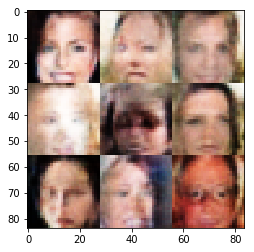

Step: 4710: Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 2.4237
Step: 4720: Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 2.5097
Step: 4730: Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 1.2900
Step: 4740: Epoch 1/2... Discriminator Loss: 0.4657... Generator Loss: 2.6448
Step: 4750: Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 1.7502
Step: 4760: Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 2.1373
Step: 4770: Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 2.7499
Step: 4780: Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 2.3260
Step: 4790: Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 2.4310
Step: 4800: Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 3.2546


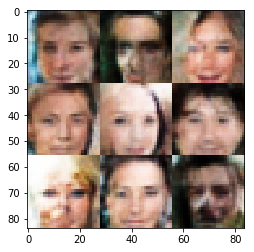

Step: 4810: Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 2.6531
Step: 4820: Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.6597
Step: 4830: Epoch 1/2... Discriminator Loss: 2.8668... Generator Loss: 0.1373
Step: 4840: Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.6792
Step: 4850: Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 0.9417
Step: 4860: Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 2.2286
Step: 4870: Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.6677
Step: 4880: Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.4397
Step: 4890: Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 2.1686
Step: 4900: Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 3.0030


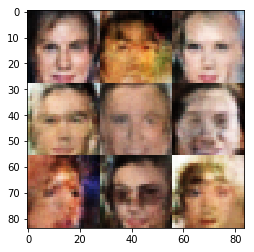

Step: 4910: Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 2.2165
Step: 4920: Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.3547
Step: 4930: Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.0200
Step: 4940: Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.4626
Step: 4950: Epoch 1/2... Discriminator Loss: 0.4985... Generator Loss: 2.0506
Step: 4960: Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.4865
Step: 4970: Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 2.4505
Step: 4980: Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 4.6866
Step: 4990: Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 1.7646
Step: 5000: Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 0.9487


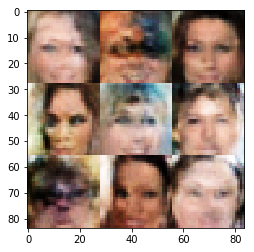

Step: 5010: Epoch 1/2... Discriminator Loss: 0.5866... Generator Loss: 1.9467
Step: 5020: Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 4.4809
Step: 5030: Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.3964
Step: 5040: Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.6007
Step: 5050: Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.3939
Step: 5060: Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 2.4247
Step: 5070: Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 3.7680
Step: 5080: Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 2.3572
Step: 5090: Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 1.9316
Step: 5100: Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 3.4102


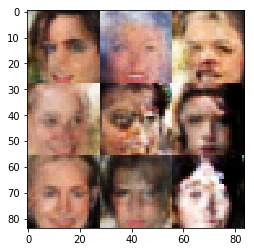

Step: 5110: Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 2.2325
Step: 5120: Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.8909
Step: 5130: Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 2.8042
Step: 5140: Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 1.8106
Step: 5150: Epoch 1/2... Discriminator Loss: 0.6918... Generator Loss: 1.3257
Step: 5160: Epoch 1/2... Discriminator Loss: 0.3942... Generator Loss: 3.3476
Step: 5170: Epoch 1/2... Discriminator Loss: 4.4550... Generator Loss: 0.0322
Step: 5180: Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 2.5527
Step: 5190: Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 2.4442
Step: 5200: Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.8191


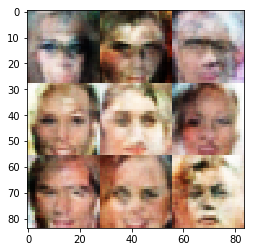

Step: 5210: Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.8047
Step: 5220: Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.3281
Step: 5230: Epoch 1/2... Discriminator Loss: 2.3981... Generator Loss: 0.2192
Step: 5240: Epoch 1/2... Discriminator Loss: 1.7744... Generator Loss: 0.4374
Step: 5250: Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 1.6038
Step: 5260: Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.1561
Step: 5270: Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 2.2030
Step: 5280: Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 2.4734
Step: 5290: Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 0.9782
Step: 5300: Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 2.3946


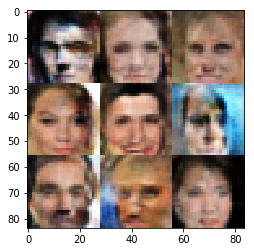

Step: 5310: Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 2.1931
Step: 5320: Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.4213
Step: 5330: Epoch 1/2... Discriminator Loss: 0.5365... Generator Loss: 1.9704
Step: 5340: Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 3.0550
Step: 5350: Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.9713
Step: 5360: Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 3.4624
Step: 5370: Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 0.9672
Step: 5380: Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 1.3215
Step: 5390: Epoch 1/2... Discriminator Loss: 5.7547... Generator Loss: 7.3309
Step: 5400: Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.6393


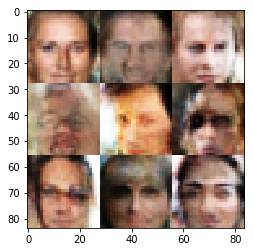

Step: 5410: Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.4416
Step: 5420: Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.2630
Step: 5430: Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.5971
Step: 5440: Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 2.9616
Step: 5450: Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 1.9973
Step: 5460: Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.9811
Step: 5470: Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 1.2807
Step: 5480: Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.8827
Step: 5490: Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.8177
Step: 5500: Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 1.9492


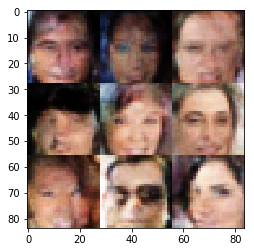

Step: 5510: Epoch 1/2... Discriminator Loss: 0.4714... Generator Loss: 2.4581
Step: 5520: Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 1.9297
Step: 5530: Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.4325
Step: 5540: Epoch 1/2... Discriminator Loss: 0.6041... Generator Loss: 1.5283
Step: 5550: Epoch 1/2... Discriminator Loss: 0.6641... Generator Loss: 1.4508
Step: 5560: Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 2.2618
Step: 5570: Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 2.3696
Step: 5580: Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.3372
Step: 5590: Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 1.7213
Step: 5600: Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 1.9907


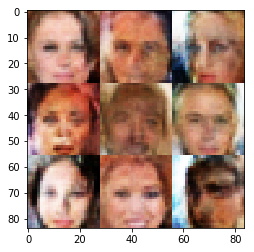

Step: 5610: Epoch 1/2... Discriminator Loss: 0.3720... Generator Loss: 4.5986
Step: 5620: Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 3.2318
Step: 5630: Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.5975
Step: 5640: Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.9062
Step: 5650: Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.4419
Step: 5660: Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.0858
Step: 5670: Epoch 1/2... Discriminator Loss: 1.7550... Generator Loss: 0.3707
Step: 5680: Epoch 1/2... Discriminator Loss: 2.4679... Generator Loss: 3.8371
Step: 5690: Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 3.1992
Step: 5700: Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.4876


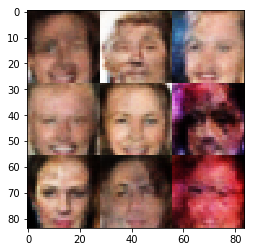

Step: 5710: Epoch 1/2... Discriminator Loss: 0.7365... Generator Loss: 1.2399
Step: 5720: Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.0644


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.